## Installing the libraries

In [66]:
!pip install matplotlib
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install matplotlib
!pip install geopandas
!pip install descartes
!pip install countryinfo
!pip install pycountry
!pip install pypopulation

## Importing libraries

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
import geopandas as gpd
import random
import pycountry
from descartes import PolygonPatch

## Reading data from CSV and processing it

In [68]:
filename = "Global_Education.csv"

dataset = pd.read_csv(filename)

# Unnecessary features
features_to_drop = ['Latitude ', 'Longitude',
       'OOSR_Pre0Primary_Age_Male', 'OOSR_Pre0Primary_Age_Female',
       'OOSR_Primary_Age_Male', 'OOSR_Primary_Age_Female',
       'OOSR_Lower_Secondary_Age_Male', 'OOSR_Lower_Secondary_Age_Female',
       'OOSR_Upper_Secondary_Age_Male', 'OOSR_Upper_Secondary_Age_Female',
        'Grade_2_3_Proficiency_Reading', 'Grade_2_3_Proficiency_Math',
       'Primary_End_Proficiency_Reading', 'Primary_End_Proficiency_Math',
       'Lower_Secondary_End_Proficiency_Reading',
       'Lower_Secondary_End_Proficiency_Math', 'Birth_Rate']

# Drop unnecessary features
dataset = dataset.drop(features_to_drop, axis=1)

# Scaling features to ensure smooth process
features_to_normalize = list(dataset.columns[1:])

# Min-Max Scaler
scaler = preprocessing.MinMaxScaler()
values = dataset[features_to_normalize].values
sc = scaler.fit_transform(values)
dataset[features_to_normalize] = pd.DataFrame(sc)

# Change Unemployment into Employment
dataset = dataset.rename(columns={'Unemployment_Rate': 'Employment_Rate'})
dataset['Employment_Rate'] = 1 - dataset['Employment_Rate']

# Dataset summary
print(dataset.head())
print(dataset.shape)

  Countries and areas  Completion_Rate_Primary_Male  \
0         Afghanistan                          0.67   
1             Albania                          0.94   
2             Algeria                          0.93   
3             Andorra                          0.00   
4              Angola                          0.63   

   Completion_Rate_Primary_Female  Completion_Rate_Lower_Secondary_Male  \
0                            0.40                                  0.49   
1                            0.96                                  0.98   
2                            0.93                                  0.49   
3                            0.00                                  0.00   
4                            0.57                                  0.42   

   Completion_Rate_Lower_Secondary_Female  \
0                                    0.26   
1                                    0.97   
2                                    0.65   
3                                    0

## SOM parameters

In [ ]:
dimensions = [20, 20]
iters = 5000
learning_rate = 0.01
radius = dimensions[0] // 2

no_features = dataset.shape[1]-1 # Subtract 1 to exclude country name
n = dataset.shape[0]

# Initialize weight matrix with random numbers
weight_matrix = np.random.random((dimensions[0], dimensions[1], no_features))

# Decay
decay = iters/np.log(radius) # found this online

## Function to assign BMUs to countries

In [70]:
def assign_bmu_to_country(dataset, weight_matrix):
    country_bmus = {}
    for i, country in enumerate(dataset['Countries and areas']):
        input_data = dataset.iloc[i, 1:].values
        bmu, _ = find_bmu(input_data, weight_matrix)
        cluster_value = np.sum(bmu) # Assigning cluster value as sum of attributes for now
        country_bmus[country] = cluster_value
    return country_bmus

country_bmus = assign_bmu_to_country(dataset, weight_matrix)

# Find the range of cluster values - helps create color map
min_cluster_value = min(country_bmus.values())
max_cluster_value = max(country_bmus.values())

print(f"Minimum cluster value: {min_cluster_value}")
print(f"Maximum cluster value: {max_cluster_value}")

Minimum cluster value: 3.12283624098019
Maximum cluster value: 8.564623872578181


## SOM plot function and plotting initial SOM

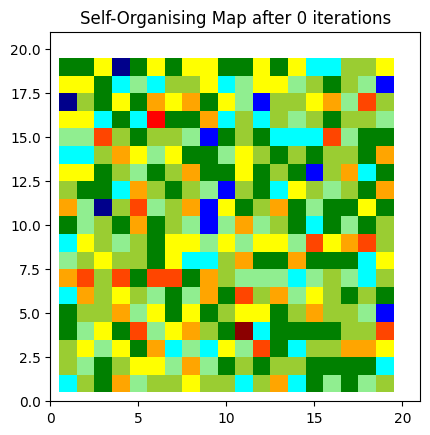

In [ ]:
# Tried to use built in colormaps
import matplotlib.cm as cm

# Custom color map
def color_map(value, min_value=min_cluster_value, max_value=max_cluster_value):

    # Normalizing values -> [0, 1]
    normalized_value = (value - min_value) / (max_value - min_value)

    colors = {
        -1.0: 'white',
        0.0: 'darkblue',
        0.1: 'blue',
        0.2: 'cyan',
        0.3: 'lightgreen',
        0.4: 'green',
        0.5: 'yellowgreen',
        0.6: 'yellow',
        0.7: 'orange',
        0.8: 'orangered',
        0.9: 'red',
        1.0: 'darkred'
    }

    # Find the closest color in the dictionary
    closest_color = colors[min(colors, key=lambda x: abs(x - normalized_value))]

    return closest_color

# Visualize SOM
def som_vis(weight_matrix, iteration):
  fig = plt.figure()
  ax = fig.add_subplot(111, aspect='equal')
  ax.set_xlim((0, weight_matrix.shape[0]+1))
  ax.set_ylim((0, weight_matrix.shape[1]+1))
  ax.set_title(f'Self-Organising Map after {iteration} iterations')

  for x in range(1, weight_matrix.shape[0]):
      for y in range(1, weight_matrix.shape[1]):
          color = color_map(np.sum(weight_matrix[x-1, y-1, :]))  # Color based on the sum of the weights
          ax.add_patch(plt.Rectangle((x-0.5, y-0.5), 1, 1, facecolor=color, edgecolor='none'))

  plt.show()

som_vis(weight_matrix, 0)

## Finding the BMU

In [72]:
def distance(x, y):
    return np.sqrt(np.sum((x - y)**2))

def find_bmu(input, network):
  low = float('inf')
  bmu_index = [0, 0]
  for i in range(network.shape[0]):
    for j in range(network.shape[1]):
      calc_dist = distance(input, network[i, j, :])
      if calc_dist < low:
        low = calc_dist
        bmu_index = [i, j]
  bmu = network[bmu_index[0], bmu_index[1], :]
  return (bmu, np.array(bmu_index)) # Using np array as it has more functions

## Main SOM algorithm

In [73]:
for i in range(iters):

  # Select random index for input vector
  r = random.randint(1, n)
  training_data = dataset.iloc[r-1, 1:].values

  # Find BMU and its index
  bmu, bmu_index = find_bmu(training_data, weight_matrix)

  # Gradual decrease in radius and learning rate
  new_rad = radius * np.exp(-i / decay)
  new_lr = learning_rate * np.exp(-i / iters)

  # Iterate through all vectors in SOM
  for x in range(weight_matrix.shape[0]):
    for y in range(weight_matrix.shape[1]):
      w = weight_matrix[x, y, :]
      # Check if within radius
      if distance(np.array([x, y]), bmu_index) <= new_rad:
        # Influence variable determines how much neuron's weight changes
        # Depending on distance from BMU
        influence = np.exp(-distance([x, y], bmu_index)**2 / (2*new_rad**2))
        new_w = w + (new_lr * influence * (training_data - w))
        weight_matrix[x, y, :] = new_w

## SOM Grid visualization - final

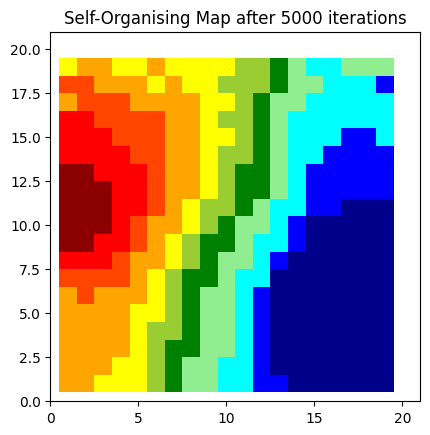

In [74]:
som_vis(weight_matrix, iters)

## Hexagonal SOM Map

## Plot on World Map  

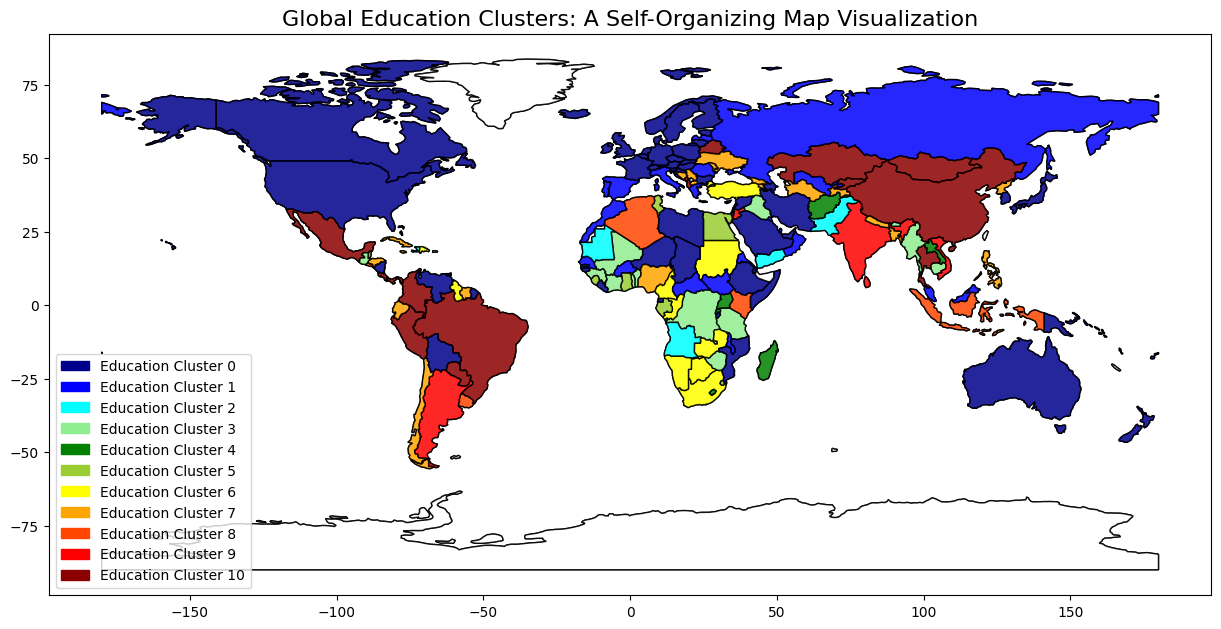

In [ ]:
# Libraries required to create legend
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Plotting on world map - GeoPandas dataset was outdated, so I had to read it from a website
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)

country_bmus = assign_bmu_to_country(dataset, weight_matrix)

# Assign colors to countries based on SOM results
# Countries not in the GeoPandas world dataset should be white
country_colors = {country: country_bmus.get(country, -1.0) for country in world['NAME_LONG']}

# print(country_colors)

# Plot the world map colored by SOM clusters
fig, ax = plt.subplots(figsize=(15, 10))
world.plot(ax=ax, color='white', edgecolor='black')

# Add patches for each country onto world map
for country, color_value in country_colors.items():
    nami = world[world['NAME_LONG'] == country]
    namigm = nami.__geo_interface__['features']

    if namigm:  # Check if features exist for the country
        namig0 = {'type': namigm[0]['geometry']['type'],
                  'coordinates': namigm[0]['geometry']['coordinates']}

        # Get the color using the color_map function
        rgba_color = color_map(color_value)

        # Plot the country with the assigned color
        ax.add_patch(PolygonPatch(namig0, fc=rgba_color, ec="black", alpha=0.85, zorder=2))

# Create legend patches
colors = list(color_map(i / 10, 0, 1) for i in range(11))
cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)

legend_patches = []
for i, color in enumerate(colors):
    patch = mpatches.Patch(color=color, label=f'Education Cluster {i}')  # Adjust label as needed
    legend_patches.append(patch)

ax.set_title('Global Education Clusters: A Self-Organizing Map Visualization', fontsize=16)
plt.legend(handles=legend_patches, loc='lower left')  # Adjust location as needed
plt.show()

## Final comments
- The countries not present in the `world` dataset from GeoPandas are colored in white
- Some ideas were borrowed from [here](https://github.com/AnisaAisha/AI_Climate-Prediction/tree/master)
and [here](https://medium.com/machine-learning-researcher/self-organizing-map-som-c296561e2117)